# Contrast and Normalization

In [61]:
import sys
import os
import csv
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import sox
import pandas as pd
import seaborn as sns
import essentia.standard as esstd
import essentia.streaming as esstr
import essentia
import pyloudnorm as pyln
import torch
from pathlib import Path
from src.data.egfxset import load_egfxset
from src.data.springset import load_springset

plt.style.use('ggplot')

In [62]:
DATA_DIR = Path('../data/raw/')
MODELS_DIR = Path('../models/')
RESULTS_DIR = Path('../data/features/')
PLOTS_DIR = Path('../docs/plots/')

In [51]:
def compute_snr(dry, wet, eps=1e-8):
    """
    Compute the Signal-to-Noise Ratio (SNR) using PyTorch.
    Values are in dB.
    """
    # reduce potential DC offset
    dry = dry - dry.mean()
    wet = wet - wet.mean()

    # compute SNR
    res = dry - wet
    snr = 10 * torch.log10(
        (wet ** 2).sum() / ((res ** 2).sum() + eps)
    )
    return snr.item()

output_file: ../audio/processed/egfx1-0-contrast.wav already exists and will be overwritten on build


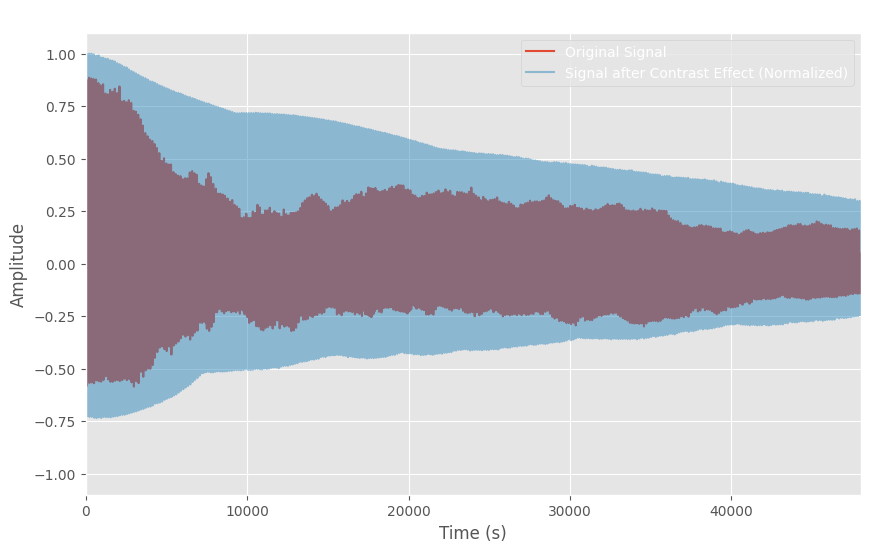

48000
input 0.000002
output -0.003598
output_norm -0.000000


In [52]:
# Create a SoX transformer
tfm = sox.Transformer()
tfm.contrast(amount=100)

os.makedirs('../audio/processed', exist_ok=True)

# Load the audio file as a numpy array
input_signal, sample_rate = sf.read('../data/raw/egfxset/Spring Reverb/Middle/1-0.wav')

# Apply the effect and specify both input and output file paths
tfm.build_file(input_filepath='../data/raw/egfxset/Clean/Middle/1-0.wav', output_filepath='../audio/processed/egfx1-0-contrast.wav')

output_signal, sample_rate = sf.read('../audio/processed/egfx1-0-contrast.wav')

output_signal_dc = output_signal - output_signal.mean()
output_signal_norm = output_signal_dc / np.max(np.abs(output_signal_dc))

zoom_factor = 1

# Plot the original, processed, and normalized signals in one plot
plt.figure(figsize=(10, 6))
plt.plot(input_signal, label="Original Signal", alpha=1.0, linewidth=1.5)
# plt.plot(output_signal, label="Signal after Contrast Effect", alpha=0.5, linewidth=1.5)
plt.plot(output_signal_norm, label="Signal after Contrast Effect (Normalized)", alpha=0.5, linewidth=1.5)
plt.title("Audio Signal Comparison")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.ylim(-1.1, 1.1)
plt.xlim(0, sample_rate*zoom_factor)
plt.legend()
plt.grid(True)
plt.show()

print(sample_rate)
print(f'input {input_signal.mean():.6f}')
print(f'output {output_signal.mean():.6f}')
print(f'output_norm {output_signal_norm.mean():.6f}')

In [64]:
dir_path = '../data/raw/egfxset_loudnorm/Clean/Middle/'

for file_name in os.listdir(dir_path):
    if file_name.endswith('.wav'):
        audio = Path(dir_path) / file_name
        print(f"Processing file: {audio}")

        # Load the audio file as a numpy array
        input_signal, sample_rate = sf.read(audio)

        meter = pyln.Meter(sample_rate)
        loudness = meter.integrated_loudness(input_signal)
        print(f'input loudness {loudness:.6f}')

Processing file: ../data/raw/egfxset_loudnorm/Clean/Middle/2-13.wav
input loudness -12.504857
Processing file: ../data/raw/egfxset_loudnorm/Clean/Middle/2-12.wav
input loudness -12.443370
Processing file: ../data/raw/egfxset_loudnorm/Clean/Middle/2-8.wav
input loudness -12.700852
Processing file: ../data/raw/egfxset_loudnorm/Clean/Middle/2-10.wav
input loudness -12.594699
Processing file: ../data/raw/egfxset_loudnorm/Clean/Middle/5-19.wav
input loudness -12.063282
Processing file: ../data/raw/egfxset_loudnorm/Clean/Middle/2-11.wav
input loudness -12.484606
Processing file: ../data/raw/egfxset_loudnorm/Clean/Middle/5-18.wav
input loudness -12.063608
Processing file: ../data/raw/egfxset_loudnorm/Clean/Middle/2-9.wav
input loudness -12.919482
Processing file: ../data/raw/egfxset_loudnorm/Clean/Middle/2-15.wav
input loudness -12.496912
Processing file: ../data/raw/egfxset_loudnorm/Clean/Middle/5-20.wav
input loudness -12.089928
Processing file: ../data/raw/egfxset_loudnorm/Clean/Middle/6-9

In [53]:
def process_folder(dir_path, dest_path):
    for file_name in os.listdir(dir_path):
        if file_name.endswith('.wav'):
            audio = Path(dir_path) / file_name
            print(f"Processing file: {audio}")

            # Load the audio file as a numpy array
            input_signal, sample_rate = sf.read(audio)

            # peak normalize audio to -3 dB
            # peak_normalized_audio = pyln.normalize.peak(input_signal, -3.0)

            # measure the loudness first 
            meter = pyln.Meter(sample_rate) # create BS.1770 meter
            loudness = meter.integrated_loudness(input_signal)

            # loudness normalize audio to -12 dB LUFS
            loudness_normalized_audio = pyln.normalize.loudness(input_signal, loudness, -12.0)

            # write the output file
            output_file = Path(dest_path) / file_name
            sf.write(output_file, loudness_normalized_audio, sample_rate, 'PCM_24')

In [54]:
process_folder('../data/raw/egfxset/Spring Reverb/Middle/', '../audio/processed/egfxset/Spring Reverb/Middle/')
process_folder('../data/raw/egfxset/Clean/Middle/', '../audio/processed/egfxset/Clean/Middle/')

Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-13.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-12.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-8.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-10.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-19.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-11.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-18.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-9.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-15.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-20.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-9.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-21.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-8.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-14.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-8.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-16.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-22.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-17.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-9.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-11.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-18.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-8.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-21.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-14.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-15.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-20.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-9.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-10.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-19.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-12.wa

/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-22.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-17.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-9.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-8.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-16.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-13.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-17.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-8.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-22.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-12.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-13.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-9.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-16.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-14.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-21.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-11.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-18.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-10.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-19.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-20.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-15.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-11.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-18.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-7.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-14.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-21.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-1.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-3.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-2.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-20.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-0.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-15.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-6.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-10.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-19.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-12.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-4.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-17.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-2.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-22.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-0.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-1.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-3.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-16.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-5.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-13.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-22.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-1.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-17.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-7.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-12.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-5.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-4.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-13.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-6.wav
Proc

/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-2.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-21.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-14.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-4.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-11.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-18.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-6.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-7.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/1-10.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-19.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-5.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/3-15.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-20.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-3.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-2.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-4.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-13.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-6.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-7.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-12.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-5.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-3.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-1.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-7.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-10.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-19.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-5.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-4.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-11.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-18.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-6.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-0.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-4.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-2.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-0.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-20.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-15.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-14.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-21.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-1.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-3.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-5.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-7.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-1.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-3.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-16.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/5-17.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-22.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/6-2.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/4-0.wav
Processing file: ../data/raw/egfxset/Spring Reverb/Middle/2-6.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-13.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-12.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-8.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-10.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-19.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-11.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-18.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-9.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-15.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-20.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Clean/Middle/6-9.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-21.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-8.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-14.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-8.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-16.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-22.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-17.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-9.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-11.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-18.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-8.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-21.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-14.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-15.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-20.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Clean/Middle/3-9.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-10.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-19.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-12.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-22.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-17.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-9.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-8.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-16.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-13.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-17.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-8.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-22.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-12.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-13.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-9.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Clean/Middle/4-16.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-14.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-21.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-11.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-18.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-10.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-19.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-20.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-15.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-11.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-18.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-7.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-14.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-21.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-1.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-3.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Clean/Middle/1-2.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-20.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-0.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-15.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-6.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-10.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-19.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-12.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-4.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-17.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-2.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-22.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-0.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-1.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-3.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-16.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Clean/Middle/5-5.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-13.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-22.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-1.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-17.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-7.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-12.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-5.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-4.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-13.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-6.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-16.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-0.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-2.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-21.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-14.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Clean/Middle/3-4.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-11.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-18.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-6.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-7.wav
Processing file: ../data/raw/egfxset/Clean/Middle/1-10.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-19.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-5.wav
Processing file: ../data/raw/egfxset/Clean/Middle/3-15.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-20.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-3.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-2.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-4.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-13.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-6.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-7.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Clean/Middle/5-12.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-5.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-3.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-1.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-7.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-10.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-19.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-5.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-4.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-11.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-18.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-6.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-0.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-4.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-2.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Clean/Middle/6-0.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-20.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-15.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-14.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-21.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-1.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-3.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-5.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-7.wav
Processing file: ../data/raw/egfxset/Clean/Middle/4-1.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-3.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-16.wav
Processing file: ../data/raw/egfxset/Clean/Middle/5-17.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-22.wav
Processing file: ../data/raw/egfxset/Clean/Middle/6-2.wav


/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
/Users/francescopapaleo/.pyenv/versions/3.11.4/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn

Processing file: ../data/raw/egfxset/Clean/Middle/4-0.wav
Processing file: ../data/raw/egfxset/Clean/Middle/2-6.wav


In [55]:
def compute_stats_of_file(data):
    min_val = np.min(data)
    max_val = np.max(data)
    mean_val = np.mean(data)
    std_val = np.std(data)
    return min_val, max_val, mean_val, std_val

def load_and_analyze_files_from_dir(directory):
    global_audio_list = []
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                
                # Load audio using essentia MonoLoader
                audio, _ = sf.read(file_path)
                
                # Compute and print stats for this file
                stats = compute_stats_of_file(audio)
                # print(f"{file}: Min: {stats[0]:.3f}, Max: {stats[1]:.3f}, Mean: {stats[2]:.3f}, Std: {stats[3]:.3f}")
                
                # Add audio data to global list
                global_audio_list.append(audio)
                
    # Compute the stats for the entire dataset from this directory
    all_data = np.concatenate(global_audio_list)
    global_stats = compute_stats_of_file(all_data)
    print(f"\nGlobal for {directory}: Min: {global_stats[0]:.3f}, Max: {global_stats[1]:.3f}, Mean: {global_stats[2]:.3f}, Std: {global_stats[3]:.3f}\n")
    print(f"Number of files: {len(global_audio_list)}")
    
    return global_audio_list

In [56]:
print("Stats for Dry Samples:")
dry_samples = load_and_analyze_files_from_dir('../audio/processed/egfxset/Clean/Middle/')

Stats for Dry Samples:

Global for ../audio/processed/egfxset/Clean/Middle/: Min: -1.000, Max: 1.000, Mean: -0.001, Std: 0.196

Number of files: 138


In [57]:
print("Stats for Wet Samples:")
dry_samples = load_and_analyze_files_from_dir('../audio/processed/egfxset/Spring Reverb/Middle/')

Stats for Wet Samples:

Global for ../audio/processed/egfxset/Spring Reverb/Middle/: Min: -1.000, Max: 1.000, Mean: 0.000, Std: 0.194

Number of files: 138


In [58]:
def extract_features_to_csv(data_loader, sample_rate, csv_filename):
    # Create and open the CSV file for writing
    with open(csv_filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        
        # Write the header row
        csv_writer.writerow(['idx', 'dry_gain', 'dry_leq', 'wet_gain', 'wet_leq'])

        for idx, (dry_data, wet_data) in enumerate(data_loader):
            dry_data_np = dry_data.numpy().squeeze().astype(np.float32)
            wet_data_np = wet_data.numpy().squeeze().astype(np.float32)
            
            pool = essentia.Pool()
            
            for data_type, data in [("dry", dry_data_np), ("wet", wet_data_np)]:
                # Instantiate the algorithms
                loader = esstr.VectorInput(data)
    
                gain = esstr.ReplayGain(sampleRate=sample_rate)
                leq = esstr.Leq()
    
                # Connect the algorithms
                loader.data >> gain.signal
                loader.data >> leq.signal
    
                # Add the features to the pool
                gain.replayGain >> (pool, f'{data_type}_gain')
                leq.leq >> (pool, f'{data_type}_leq')
    
                # Run the network
                essentia.run(loader)
    
            # Extract features
            dry_gain = np.array(pool['dry_gain']).flatten()[0]
            dry_leq = np.array(pool['dry_leq']).flatten()[0]
            wet_gain = np.array(pool['wet_gain']).flatten()[0]
            wet_leq = np.array(pool['wet_leq']).flatten()[0]
    
            print(f'Sample {idx}, dry_gain: {dry_gain}, dry_leq: {dry_leq}, wet_gain: {wet_gain}, wet_leq: {wet_leq}')
            
            # Write the features for this sample to the CSV file
            csv_writer.writerow([idx, dry_gain, dry_leq, wet_gain, wet_leq])

train_loader, _, _ = load_egfxset(data_dir='../audio/processed/', batch_size=1, train_ratio=1.0, valid_ratio=0.0, test_ratio=0.0)

# Example usage
sample_rate = 48000
csv_filename = '../audio/processed/egfxset/features.csv'
extract_features_to_csv(train_loader, sample_rate, csv_filename)

Total size: 138
Sample 0, dry_gain: -19.693504333496094, dry_leq: -9.400430679321289, wet_gain: -19.727174758911133, wet_leq: -9.5546236038208
Sample 1, dry_gain: -20.476863861083984, dry_leq: -11.916743278503418, wet_gain: -21.793487548828125, wet_leq: -10.36411190032959
Sample 2, dry_gain: -21.14012336730957, dry_leq: -10.097244262695312, wet_gain: -21.023395538330078, wet_leq: -10.402286529541016
Sample 3, dry_gain: -21.469369888305664, dry_leq: -9.25479793548584, wet_gain: -19.3289794921875, wet_leq: -8.836958885192871
Sample 4, dry_gain: -18.832229614257812, dry_leq: -9.85510540008545, wet_gain: -19.66769027709961, wet_leq: -11.210187911987305
Sample 5, dry_gain: -20.63644027709961, dry_leq: -9.434343338012695, wet_gain: -20.104440689086914, wet_leq: -10.006444931030273
Sample 6, dry_gain: -20.881908416748047, dry_leq: -9.28704833984375, wet_gain: -20.29732894897461, wet_leq: -10.433013916015625
Sample 7, dry_gain: -20.664649963378906, dry_leq: -7.95367956161499, wet_gain: -20.641

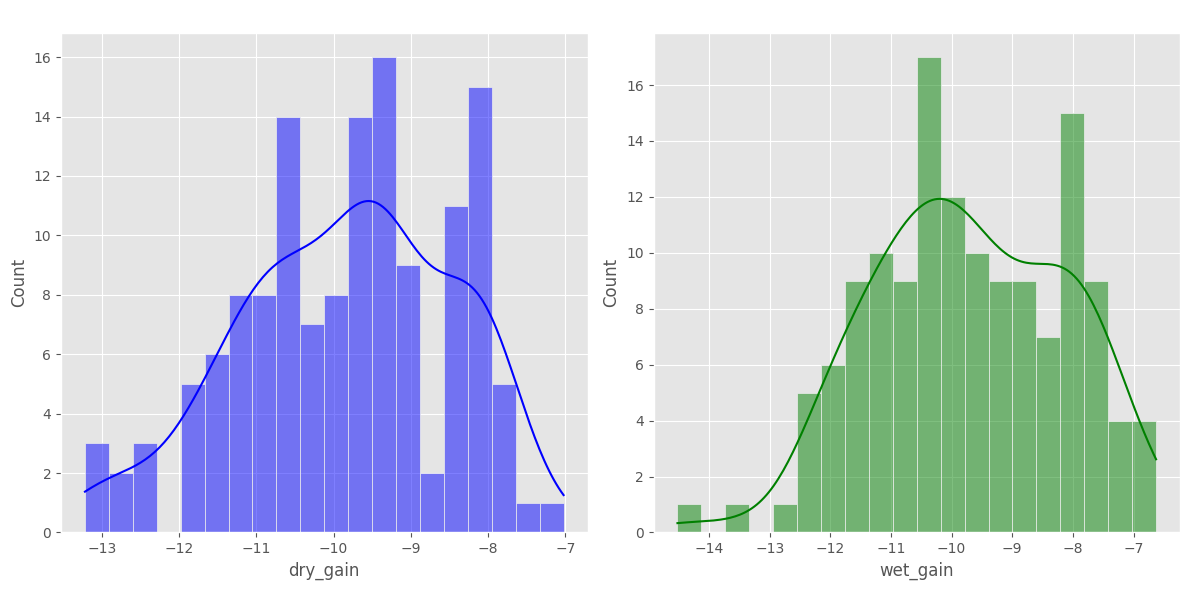

In [59]:
# Load the CSV file into a Pandas DataFrame
csv_filename = '../audio/processed/egfxset/features.csv'
df = pd.read_csv(csv_filename)

# Separate the dry and wet data
dry_data = df[['idx', 'dry_gain', 'dry_leq']]
wet_data = df[['idx', 'wet_gain', 'wet_leq']]

# Plot the distribution of dry_gain and wet_gain
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=dry_data, x='dry_leq', bins=20, kde=True, color='blue')
plt.title('Distribution of Leq (dry samples)')
plt.xlabel('dry_gain')

plt.subplot(1, 2, 2)
sns.histplot(data=wet_data, x='wet_leq', bins=20, kde=True, color='green')
plt.title('Distribution of Leq (wet samples))')
plt.xlabel('wet_gain')

plt.tight_layout()
plt.show()

# Similarly, you can create plots for dry_leq and wet_leq

In [60]:
import os
from pathlib import Path
import essentia as es
import essentia.streaming as estr

def process_folder(file_path):
    for file_name in os.listdir(file_path):
        if file_name.endswith('.wav'):
            audio = Path(file_path) / file_name
            print(f"Processing file: {audio}")

            # Create the streaming network
            loader = estr.MonoLoader(filename=str(audio), sampleRate=48000)
            dc = estr.DCRemoval(sampleRate=48000)
            gain = estr.ReplayGain(sampleRate=48000)

            # Create the output file
            output_file = Path('../audio/processed') / file_name
            writer = estr.MonoWriter(filename=str(output_file), sampleRate=48000)

            # Connect the streaming algorithms
            loader.audio >> dc.signal
            dc.signal >> gain.signal
            gain.replayGain >> writer.audio

            # Run the streaming network
            es.run(loader)

            # Get the replayGain value
            replay_gain = gain.replayGain
            print(f"ReplayGain: {replay_gain} dB")
        else:
            print(f"Skipping file: {file_name}")
